# FPGA Setup
This first cell loads the fpga program bitstream, then sets things up so that Python can read & write to memory that's shared between the operating system and fpga.  The specifics of what memory locations do what are set up beforehand when programming the fpga.

In [1]:
import sys
from time import sleep
from time import gmtime, strftime
import mmap
import resource
import numpy as np
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import FileLink, FileLinks
from IPython.display import clear_output
import datetime
%matplotlib inline

# This sets up the FPGA and maps some memory locations to variables we can access
# Don't change anything here unless you enjoy things not working.
os.system('cat /root/system_wrapper.bit > /dev/xdevcfg')
#os.system('cat /opt/redpitaya/fpga/pet_rebuild.bit > /dev/xdevcfg')

fd = os.open('/dev/mem', os.O_RDWR)
mm = []
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41210000)) #0
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41300000)) #1
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41200000)) #2
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41230000)) #3
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41240000)) #4
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41250000)) #5
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41220000)) #6
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41260000)) #7
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41270000)) #8
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41280000)) #9
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41290000)) #10
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x412A0000)) #11
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x412B0000)) #12
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x412C0000)) #13
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x412D0000)) #14
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x42220000)) #15
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x412E0000)) #16
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x412F0000)) #17
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41310000)) #18
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41320000)) #19
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41330000)) #20
mm.append(mmap.mmap(fileno=fd, length=mmap.PAGESIZE, offset=0x41340000)) #21

lat_in  = np.frombuffer(mm[0], dtype='uint32') 
lat_out = np.frombuffer(mm[1], dtype='uint32') 
rot_in  = np.frombuffer(mm[2], dtype='uint32') 
ch1_threshold = np.frombuffer(mm[3], dtype='uint32') 
ch2_threshold = np.frombuffer(mm[4], dtype='uint32') 
coincidence_settings = np.frombuffer(mm[5], dtype='uint16') 
threshold_invert_settings = np.frombuffer(mm[6], dtype='uint32') 
coincidence_timeout_counts  = np.frombuffer(mm[7], dtype='uint32') 
counts  =  np.frombuffer(mm[8], dtype='uint32') 
uthreshold_counts =  np.frombuffer(mm[9], dtype='uint32') 
coincidence_status =  np.frombuffer(mm[10], dtype='uint32') 
raw_input = np.frombuffer(mm[11],count=2,dtype='int16') # ADC data is stored as a signed integer
sensor_readout = np.frombuffer(mm[11],offset=8,count=1,dtype='uint32') # This skips the first 4 bytes, getting to the readout info.
threshold_detection = np.frombuffer(mm[12],dtype='uint32')
adc_module_signal = np.frombuffer(mm[13],dtype='uint32')
direct_adc = np.frombuffer(mm[14],dtype='uint32')
offset_settings = np.frombuffer(mm[15],dtype='uint32')
dac_settings = np.frombuffer(mm[16],dtype='uint32')
rotation_settings = np.frombuffer(mm[17],dtype='int32')

PHA_readout = np.frombuffer(mm[18],dtype='uint32')
PHA_stored_pulses = np.frombuffer(mm[19],dtype='uint32')
toggler  = np.frombuffer(mm[20],dtype='uint32')
scan_runtime = np.frombuffer(mm[21],dtype='uint32')


# Initial Settings
To start off, you'll want to set what readings correspond to an acceptable 511 keV signal.  The units on these thresholds go from $0$ (around +1V) to $2^{14}-1 = 16383$, which roughly corresponds to -1 V.  Why these specific numbers?  Because the input has an Analog to Digital Converter (ADC) that maps the +1 V to -1 V range to a 14-bit number.

0 V is around a readout of 8192, so in this instance we're looking for pulses around -35 to mV -220 mV  

We're also telling the software that we want to invert the threshold, which means we're looking for a signal less than 0V.

In [2]:
threshold_invert_settings[0] = 1
threshold_invert_settings[2] = 1

# Translating FPGA data
All of the variables that are used to communicate back-and-forth with the FPGA are numerical.  Thus, in order to translate what some of the signals mean we've defined a few Python dictionaries that define both a number and its meaning.

In [3]:
coincidence_dict = {0:"Idle",
                    1:"Signal on ch 1",
                    2:"Signal on ch 2",
                    3:"Coincidence detected",
                    4:"Timeout no signal on 2",
                    5:"Coincidence detection loop finished",
                    6:"Error",
                    7:"Ch1 over threshold",
                    8:"Ch2 over threshold",
                    9:"Timeout no signal on 1",
                    10:"Recover"}
rotation_dict =    {0:"Idle",
                    1:"Running",
                    2:"Run Finished",
                    3:"Resetting",
                    4:"Timeout before reset finished",
                    19:"Resetting: First pass detected",
                    35:"Resetting: Second pass",
                    36:"Reset Timeout"}
lateral_dict =     {0:"Idle",
                    1:"Running",
                    2:"Run Finished",
                    3:"Resetting",
                    4:"Error",
                    19:"Resetting: First pass detected",
                    35:"Resetting: Second pass",
                    36:"Reset Timeout"}
DAC_dict =          {0:"Ch 1 Low Threshold",
                     1:"Ch 1 High Threshold",
                     2:"Ch 1 Input",
                     3:"CH 2 Input",
                     4:"Lateral Motor Signals",
                     5:"Rotational Motor Signals",
                     6:"Ch 2 Low Threshold",
                     7:"Ch 2 High Threshold",
                     8:"Ch 1 Low Pulse",
                     9:"Ch 2 Low Pulse",
                     128: "Ch 1 Both Thresholds",
                     129: "Ch 2 Both Thresholds"}

# Utility Functions
----

While what's here is technically enough for you to work with, it isn't very user friendly or intuitive.  Thus, we define a few useful functions that will send appropriate series of commands to perform basic tasks. `lat_move()` and `rot_move()` are used to move the platform lateraly and rotate it, respectively.  The first argument is a direction and the second is a distance.  

`lat_reset()` and `rot_reset()` will reset the platform to known positions, which is useful for starting out.  Note that the rotational reset will *only* work after a lateral reset, otherwise the sensor that detects the platform's rotation will not be in the correct place.

`get_counts()` will start counting coincidences using the current settings, and returns the number of coincidences detected.  It also uses the `seconds_to_ticks()` function to translate the time you put in to Red Pitaya clock cycles so you don't have to do so manually.

In [4]:
import math

def seconds_to_ticks(ts):
    return math.ceil(ts*1.25e8) #The Red Pitaya has a 125 MHz clock

def lat_move(dr,dist):
   # print("initial:",lat_in[0])
    try:
        lat_in[2] = dist
    except e:
        print("Invalid distance of ",dist)
        raise e
    if dr == 0:
        lat_in[0] = lat_in[0]|0b10    
    else:
        lat_in[0] &= ~0b10
    #print("After dr set",lat_in[0])
    lat_in[0] = lat_in[0]|0b1
    #print("After start set",lat_in[0])
    sleep(0.001)
    lat_in[0] &= ~0b1 # Guarantees set to zero
    #print("After toggle", lat_in[0])
    while(lat_out[0] ==1):
        pass # waits while the setup is moving
    #print(lat_in[0])
    if(lat_out[0] == 2):
        lat_in[0] = 8
        sleep(0.001)
        lat_in[0] = 0
    #print("End",lat_in[0])
    if(lat_out[0] == 4):
        raise RuntimeError("Controller returned error code")

def rot_move(dr,dist):
    try:
        rot_in[2] = dist
    except e:
        print("Invalid distance of ",dist)
        raise e
    if dr == 0:
        rot_in[0] = rot_in[0]|0b10    
    else:
        rot_in[0] &= ~0b10
    rot_in[0] = rot_in[0]|0b1
    sleep(0.001)
    rot_in[0] &= ~0b1 # Guarantees set to zero
    while(rotation_settings[0] == 1):
        pass # waits while the setup is moving
    #print(rotation_settings[0])
    if(rotation_settings[0] == 2):
        rot_in[0] = 8
        rot_in[0] = 0
        
def lat_reset():
    lat_in[0] = lat_in[0]|0b100
    sleep(0.001)
    lat_in[0] &= ~0b001 # Guarantees set to zero
    while(lat_out[0] ==3):
        pass # waits while the setup is moving
    if(lat_out[0] == 4):
        raise RuntimeError("Controller returned error code")
    sleep(1.1)
    lat_in[0] = 8
    sleep(0.001)
    lat_in[0] = 0  
             
def rot_reset():
    rot_in[0] = rot_in[0]|0b100
    sleep(0.001)
    rot_in[0] &= ~0b001 # Guarantees set to zero
    while(rotation_settings[0] >=3 or rotation_settings[0] ==19 ):
        pass # waits while the setup is moving
    if(rotation_settings[0] == 2):
        rot_in[0] = 8
        sleep(0.001)
        rot_in[0] = 0  
    sleep(1.1)
        
def get_counts(time = 1,s1=coincidence_settings, s2=scan_runtime,progress=None,show_counts=None):
    s1[0] = 1
    sleep(0.001)
    global scan_runtime
    s2[0] = seconds_to_ticks(time)
    s1[0] = 3
    sleep(0.001)
    s1[0] = 2
    for i in range(time):
        sleep(1)
        with show_counts:
            clear_output(wait=True)
            print("Counts: {}".format(coincidence_timeout_counts[0]))
        progress.value = 100*i/(time-1)
    coinc = coincidence_timeout_counts[0]
    ch1 = counts[0]
    ch2 = counts[2]
    s1[0] = 3
    sleep(0.001)
    s1[0] = 0
    return coinc,ch1,ch2

def get_data():
    return lat_out[2], rotation_settings[2], coincidence_timeout_counts[0]

def set_threshold(channel,kind,value):
    if channel == 1:
        if kind == 'lower':
            ch1_threshold[0] = value
        if kind == 'upper':
            ch1_threshold[2] = value
    if channel == 2:
        if kind == 'lower':
            ch2_threshold[0] = value
        if kind == 'upper':
            ch2_threshold[2] = value       
    with header:
        clear_output(wait=True)
        print("Coincidence settings")
        print("   Ch1 {:5d} - {:5d}".format(ch1_threshold[0],ch1_threshold[2]))
        print("   Ch2 {:5d} - {:5d}".format(ch2_threshold[0],ch2_threshold[2]))
        print("Offsets")
        print("   Ch1 {}".format(offset_settings[0]))
        print("   Ch2 {}".format(offset_settings[2]))
    global header_txt  # Not good practice, but it works.
    header_txt = make_header()
        
def set_offset(channel,value):
    if channel == 1:
        offset_settings[0] = value
    if channel == 2:
        offset_settings[2] = value
    with header:
        clear_output(wait=True)
        print("Coincidence settings")
        print("   Ch1 {:5d} - {:5d}".format(ch1_threshold[0],ch1_threshold[2]))
        print("   Ch2 {:5d} - {:5d}".format(ch2_threshold[0],ch2_threshold[2]))
        print("Offsets")
        print("   Ch1 {}".format(offset_settings[0]))
        print("   Ch2 {}".format(offset_settings[2]))
    global header_txt
    header_txt = make_header()

# Loading Commands

In order to run a series of commands back-to-back, we'll write them as a file and then load the list using the following commands.  The file is written in JavaScript Object Notation(JSON) format, which consists of pairs of variable names and values in a nested structure.  We'll provide several examples to help you get started.

The `parse_commands()` function might look a little odd; it is set up to convert a loop into discrete commands.

In [55]:
import json
from time import gmtime, strftime
import codecs

'''
def load_json(fname):
    with open(fname,"r") as f:
        fdata = f.read()
    return(json.loads(fdata)['Program'])
'''
def load_json(f_widget):
    return json.loads(codecs.decode(f_widget, encoding="utf-8"))
        
time_estimate = 0
    
def parse_commands(clist):
    cmds = []
    loop_flag = 0
    for item in clist:
        if item['Name'] != 'LOOP':
            cmds.append(item)
        else:
            loop_flag = 1
            for i in range(item['Times']):
                for subitem in item['List']:
                    cmds.append(subitem)
    if loop_flag == 1:
        return(parse_commands(cmds))
    else:
        return(cmds)

In [56]:
from ipywidgets import FileUpload
if 'f_upload' in locals():
    del(f_upload)
f_upload = FileUpload(accept='.json', multiple=False )
display(f_upload)

FileUpload(value={}, accept='.json', description='Upload')

----
# Don't continue before you select your file

In [57]:
cmd_fname = "threeovernight.json"
cmd_raw = load_json(f_upload.value[list(f_upload.value.keys())[0]]['content'])
cmd_list = parse_commands(cmd_raw['Program'])
time_estimate = 0

for item in cmd_list:
    if item['Name'] =='Scan':
        time_estimate += item['Time']
    if item['Name'] == 'ResetLateral':
        time_estimate += 30
    if item['Name'] == 'ResetRotation':
        time_estimate += 15
hr = time_estimate//3600
mn = (time_estimate - (hr*3600))//60
print("Commands should take around {} hours, {} minutes to run".format(hr,mn))
import pprint
pp = pprint.PrettyPrinter()
pp.pprint(cmd_list)

Commands should take around 0 hours, 30 minutes to run
[{'Name': 'ResetLateral'},
 {'Name': 'ResetRotation'},
 {'Channel': 1, 'Kind': 'lower', 'Name': 'Threshold', 'Value': 8550},
 {'Channel': 1, 'Kind': 'upper', 'Name': 'Threshold', 'Value': 8600},
 {'Channel': 2, 'Kind': 'lower', 'Name': 'Threshold', 'Value': 8440},
 {'Channel': 2, 'Kind': 'upper', 'Name': 'Threshold', 'Value': 8500},
 {'Channel': 1, 'Name': 'Offset', 'Value': 0},
 {'Channel': 2, 'Name': 'Offset', 'Value': 0},
 {'Dir': 2, 'Dist': 20000, 'Name': 'Move'},
 {'Dir': 2, 'Dist': 500, 'Name': 'Move'},
 {'Name': 'Scan', 'Time': 15},
 {'Dir': 2, 'Dist': 500, 'Name': 'Move'},
 {'Name': 'Scan', 'Time': 15},
 {'Dir': 2, 'Dist': 500, 'Name': 'Move'},
 {'Name': 'Scan', 'Time': 15},
 {'Dir': 2, 'Dist': 500, 'Name': 'Move'},
 {'Name': 'Scan', 'Time': 15},
 {'Dir': 2, 'Dist': 500, 'Name': 'Move'},
 {'Name': 'Scan', 'Time': 15},
 {'Dir': 2, 'Dist': 500, 'Name': 'Move'},
 {'Name': 'Scan', 'Time': 15},
 {'Dir': 2, 'Dist': 500, 'Name': '

# Save file setup

To start with, we'll create a new filename with important info like when your data was taken along with the triggering thresholds.

In [58]:
def make_header():
    start_time = gmtime()
    header = "Log start time:\t {}\n".format(strftime("%a, %d %b %Y %H:%M:%S", start_time))
    header += "Ch1 Lower Trigger Threshold:\t{} \n".format(ch1_threshold[0])
    header += "Ch1 Upper Trigger Threshold:\t{} \n".format(ch1_threshold[2])
    header += "Ch1 Offset Value:\t{} \n".format(offset_settings[0])
    header += "Ch2 Lower Trigger Threshold:\t{} \n".format(ch2_threshold[0])
    header += "Ch2 Upper Trigger Threshold:\t{} \n".format(ch2_threshold[2])
    header += "Ch2 Offset Value:\t{} \n".format(offset_settings[2])
    header += "{:>10s}{:>10s}{:>10s}{:>14s}{:>14s}{:>16s}".format(*data_columns) # this adds the column names to the file
    return header
    
start_time = gmtime()    
fname = "PetScan_"+strftime("%b%d_Time_%H_%M_%S",start_time)+".csv" #This just adds the current day/time to the filename
 
data_columns = ['x','theta','time','ch1 counts','ch2 counts', 'coincidences']
header_txt = make_header()
import pandas as pd
current_data = pd.DataFrame(data = None,columns =data_columns)

# Running Commands
Finally, we have the code that will excecute the commands in your file.  This is actually the simplest part, as it calls the functions we defined earlier based on the commands you wrote.

In [59]:
from IPython.display import FileLink, FileLinks
header = widgets.Output()
cur_cmd = widgets.Output()
cur_time = widgets.FloatProgress(value = 0, min = 0, max = 100,description="Scan Time")
cur_coinc = widgets.Output()
general_output = widgets.Output()
display(header)
display(cur_cmd)
display(cur_coinc)
display(cur_time)
display(general_output)

last_cmd = None

with header:
    clear_output(wait=True)
    print("Coincidence settings")
    print("   Ch1 {:5d} - {:5d}".format(ch1_threshold[0],ch1_threshold[2]))
    print("   Ch2 {:5d} - {:5d}".format(ch2_threshold[0],ch2_threshold[2]))
    print("Offsets")
    print("   Ch1 {}".format(offset_settings[0]))
    print("   Ch2 {}".format(offset_settings[2]))
    
with general_output:
    hr = time_estimate//3600
    mn = (time_estimate - (hr*3600))//60
    print("Commands should take around {} hours, {} minutes to run\n".format(hr,mn))
    print("{:>10s}{:>10s}{:>10s}{:>14s}{:>14s}{:>16s}".format(*data_columns)) # This looks awful, but just prints out the relevant variable names

for item in cmd_list:
    with cur_cmd:
        clear_output(wait=True)
        print("Previous Command: {}".format(last_cmd))
        print("Current Command: {}".format(item['Name']))
        last_cmd = item['Name']
    if item['Name'] == 'ResetLateral':
        lat_reset()
    if item['Name'] == 'ResetRotation':
        rot_reset()
    if item['Name'] == 'Threshold':
        set_threshold(item['Channel'],item['Kind'],item['Value'])
    if item['Name'] == 'Offset':
        set_offset(item['Channel'],item['Value'])
    if item['Name'] == 'Move':
        lat_move(item['Dir'],item['Dist'])
    if item['Name'] =='Rotate':
        rot_move(item['Dir'],item['Dist'])
    if item['Name'] =='Scan':
        c,c1,c2 = get_counts(item['Time'],progress = cur_time,show_counts=cur_coinc)
        newest_data = pd.DataFrame([[lat_out[2],rotation_settings[2],item['Time'],c1,c2,c]],columns=data_columns )
        with general_output:
            print("{:>10d}{:>10d}{:>10d}{:>14d}{:>14d}{:>16d}".format(lat_out[2], rotation_settings[2],item['Time'],c1,c2,c))
        current_data = pd.concat([current_data,newest_data])
        np.savetxt(fname,current_data.values, delimiter=',',header=header_txt,fmt='%12d,%9d,%9d,%13d,%13d,%15d') # Added to save intermediate data
with cur_cmd:
    clear_output(wait=True)
    print("Scan finished")
    
display(FileLink(fname))

#This just makes it beep at you when it finishes
import IPython.display as ipd
sr = 44000 # sample rate
T = 1.3    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
for index, value in enumerate(t):
    if (index%10000) > 5000:
        t[index]= 0
x = 0.25*np.sin(2*np.pi*440*t) 
x[0] = 1
ipd.Audio(x,rate=sr,autoplay=True)

Output()

Output()

Output()

FloatProgress(value=0.0, description='Scan Time')

Output()

/home/jupyter/RedPitaya/PetScan_Nov04_Time_21_35_05.csv

----

<IPython.core.display.Javascript object>


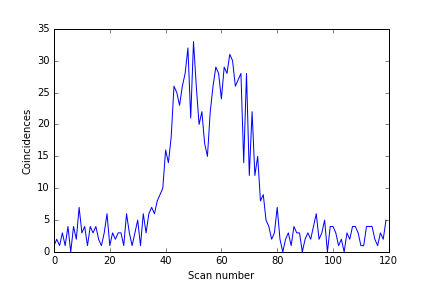

In [60]:
%matplotlib notebook
from matplotlib import pyplot as plt
fig,ax = plt.subplots()
ax.set_xlabel("Scan number")
ax.set_ylabel("Coincidences")
ax.plot(current_data['coincidences'].values)